# Predicting Ski Resort Lift Ticket Prices
### By Group 28

## Introduction

**Background**

Lift ticket prices have been rising rapidly with the increasing costs of running ski resorts. This can be attributed to many factors, including higher maintenance and operation costs as well as rising employee wages and inflationary pressures. Moreover, there is an increased demand for skiing and snowboarding, leading to more competitive markets, resulting in higher lift ticket prices for the average consumer. A European Commission report published in 2021 shows the average daily lift ticket price for the 2019/2020 ski season was €54 per day in Europe. Compared to the last season, this represents an increase of 4%, and from 10 years ago it represents an increase of 18%. We can only expect prices to keep rising, making the already expensive sport ever more expensive (European Commission, 2021).  

Our dataset, uploaded by user **thomasnibb** on Kaggle features information about ~370 ski resorts all over Europe. The dataset contains 15 columns of information, six of which are considered variables of interest pertinent to our study: 
- **Highest Point**
- **Lowest Point**
- **Total Slope**
- **Total Lifts**
- **Lift Capacity**
- **Snow Cannons**

**Research Question**

Through this analysis, we aim to gain insight into the impact of these features on the prices and the relation they each have with it. This study is particularly important as understanding the relation between these variables and lift ticket prices can help consumers make more informed decisions about when and where to ski or snowboard, and can help them identify opportunities to save money on lift tickets. Furthermore, this analysis provides an opportunity for newly established resorts to gain insights into consumer behavior and patterns, and set fair market prices accordingly. 

### Attaching Libraries

First we include all of the libraries needed to perform our various methods and functions in R.

In [1]:
# Run First
library(tidyverse)
library(repr)
library(infer)
library(cowplot)
library(tidymodels)
library(GGally)
library(ISLR)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ modeldata    1.0.0     ✔ workflows    1.0.0
✔ parsnip      1.0.0     ✔ workflowsets 1.0.0
✔ recipes      1.0.1     ✔ yardstick    1.0.0

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::st

### Reading and Cleaning Data

Here we download the dataset that has been rehosted as a raw table in our GitHub repository and remove the first two columns, row number and the resort names as they are not relevant to our model.

In [2]:
# Reading the Data
url <- "https://raw.githubusercontent.com/alextdart/dsci100-group28-2022wt2/main/European_Ski_Resorts.csv"
raw_data <- read_csv(url, show_col_types = FALSE)

# Removing Unneeded Columns (Resort Name and Row Number)
ski_data <- raw_data |>
    select(HighestPoint:SnowCannons)

### Exploratory Data Analysis

In [3]:
# Summary
summary(ski_data)

  HighestPoint   LowestPoint     DayPassPriceAdult BeginnerSlope   
 Min.   :   0   Min.   :   0.0   Min.   : 0.00     Min.   :  0.00  
 1st Qu.:1550   1st Qu.: 779.2   1st Qu.:34.00     1st Qu.:  8.00  
 Median :2104   Median :1050.0   Median :42.00     Median : 19.00  
 Mean   :2052   Mean   :1055.1   Mean   :40.78     Mean   : 35.87  
 3rd Qu.:2568   3rd Qu.:1350.0   3rd Qu.:49.00     3rd Qu.: 40.00  
 Max.   :3899   Max.   :2180.0   Max.   :81.00     Max.   :312.00  
 IntermediateSlope DifficultSlope     TotalSlope      Snowparks        
 Min.   :  0.00    Min.   :  0.00   Min.   :  0.00   Length:376        
 1st Qu.:  9.00    1st Qu.:  2.00   1st Qu.: 25.00   Class :character  
 Median : 22.00    Median :  5.00   Median : 48.00   Mode  :character  
 Mean   : 38.35    Mean   : 11.78   Mean   : 86.26                     
 3rd Qu.: 42.25    3rd Qu.: 13.00   3rd Qu.:100.00                     
 Max.   :239.00    Max.   :103.00   Max.   :600.00                     
   NightSki         

We then break down the data into its constituents and graph them to better view their relationships with Day Pass Price. This assists us in detecting the most applicable data points so we do not have to use a fourteen variable regression model.

### Selecting Variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



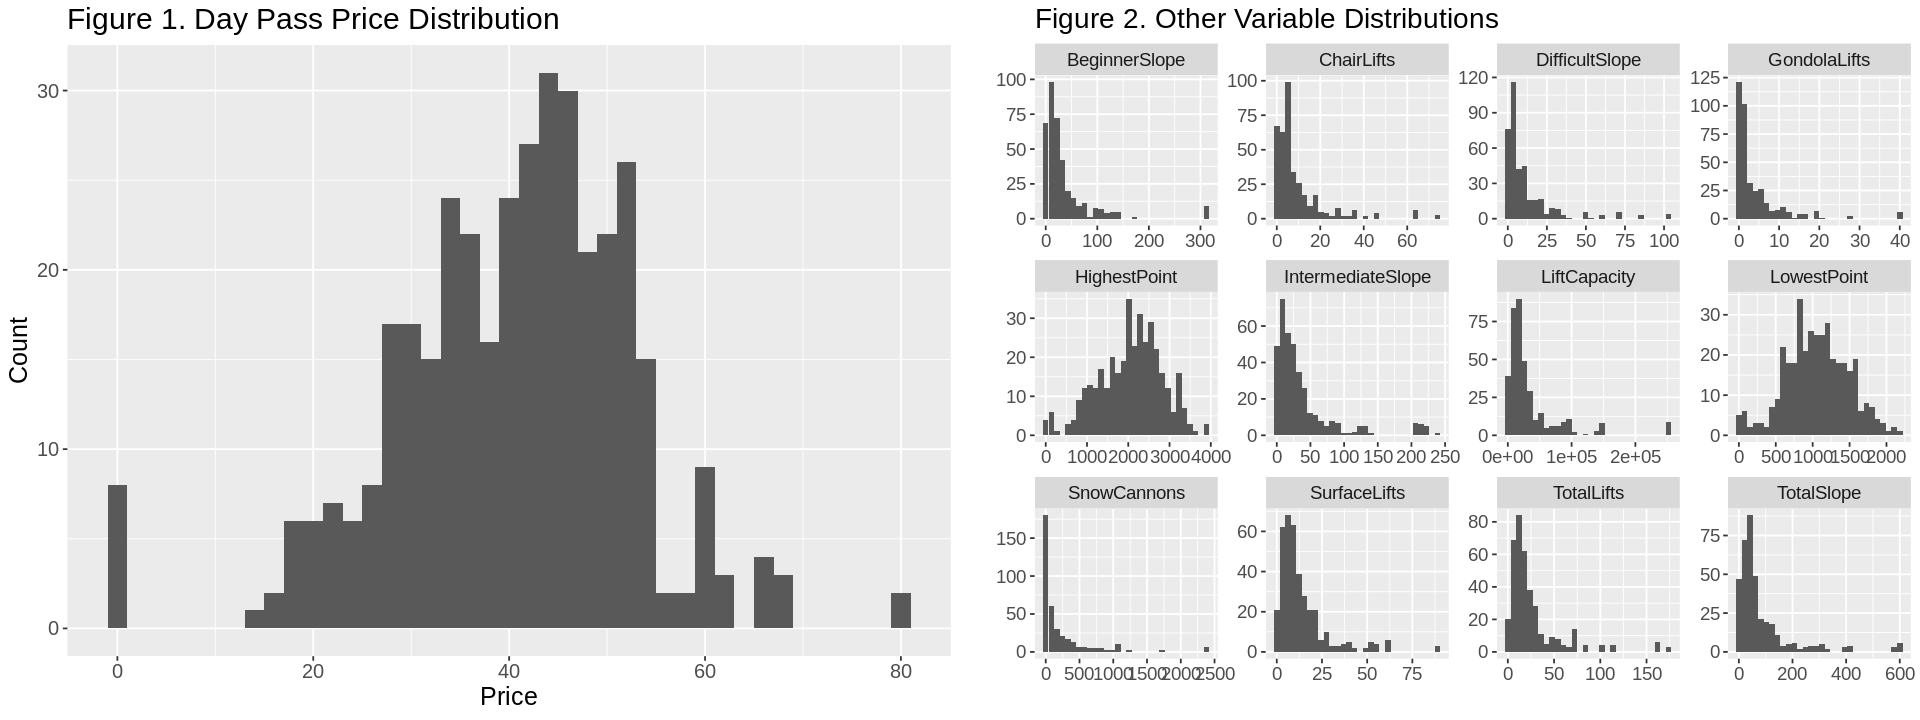

In [4]:
# Response Variable Distribution Chart
daypass_dist <- ski_data |>
    ggplot(aes(x = DayPassPriceAdult)) +
    geom_histogram(binwidth = 2) +
    labs(title = "Figure 1. Day Pass Price Distribution", x = "Price", y = "Count")+
    theme(text=element_text(size=15))

# Other Variable Distributions Chart
other_eda_dists <- ski_data |>
    keep(is.numeric) |>
    select(-DayPassPriceAdult) |>
    gather() |>
    ggplot(aes(value)) +
    facet_wrap(~ key, scales = "free") +
    geom_histogram() +
    labs(title = "Figure 2. Other Variable Distributions", x = "", y = "")+
    theme(text=element_text(size=14))

options(repr.plot.width = 16, repr.plot.height = 6)
plot_grid(daypass_dist, other_eda_dists, ncol = 2)

From Figure 1, we select the "total" variables as they show a stronger representation of the ski resorts and thus offer better data models. We also select SnowCannons, LiftCapacity, and height variables, because they represent the main aspects of a ski resort and show greater relation with the pass price than the other data.

From here we calculate the correlations between our result variable - DayPassPriceAdult - and each of them.

In [5]:
# Correlation with Day Pass Price of Major Variables of Interest
ski_correlation <- ski_data |>
    select(DayPassPriceAdult, HighestPoint, LowestPoint,  
           TotalSlope, TotalLifts, LiftCapacity, SnowCannons) |>
    cor() |>
    round(3) 
    
ski_correlation[1,2:7]

HighestPoint  LowestPoint   TotalSlope   TotalLifts LiftCapacity  SnowCannons 
       0.533        0.202        0.509        0.463        0.463        0.391

From here, despite the correlation of the lowest point data being low, we chose to keep it as we found removing it drastically lowers accuracy. We then continue on to use ggpairs to investigate their correlations with the pass price visually, along with their correlations to each other to ensure we didn't miss any important predictors.

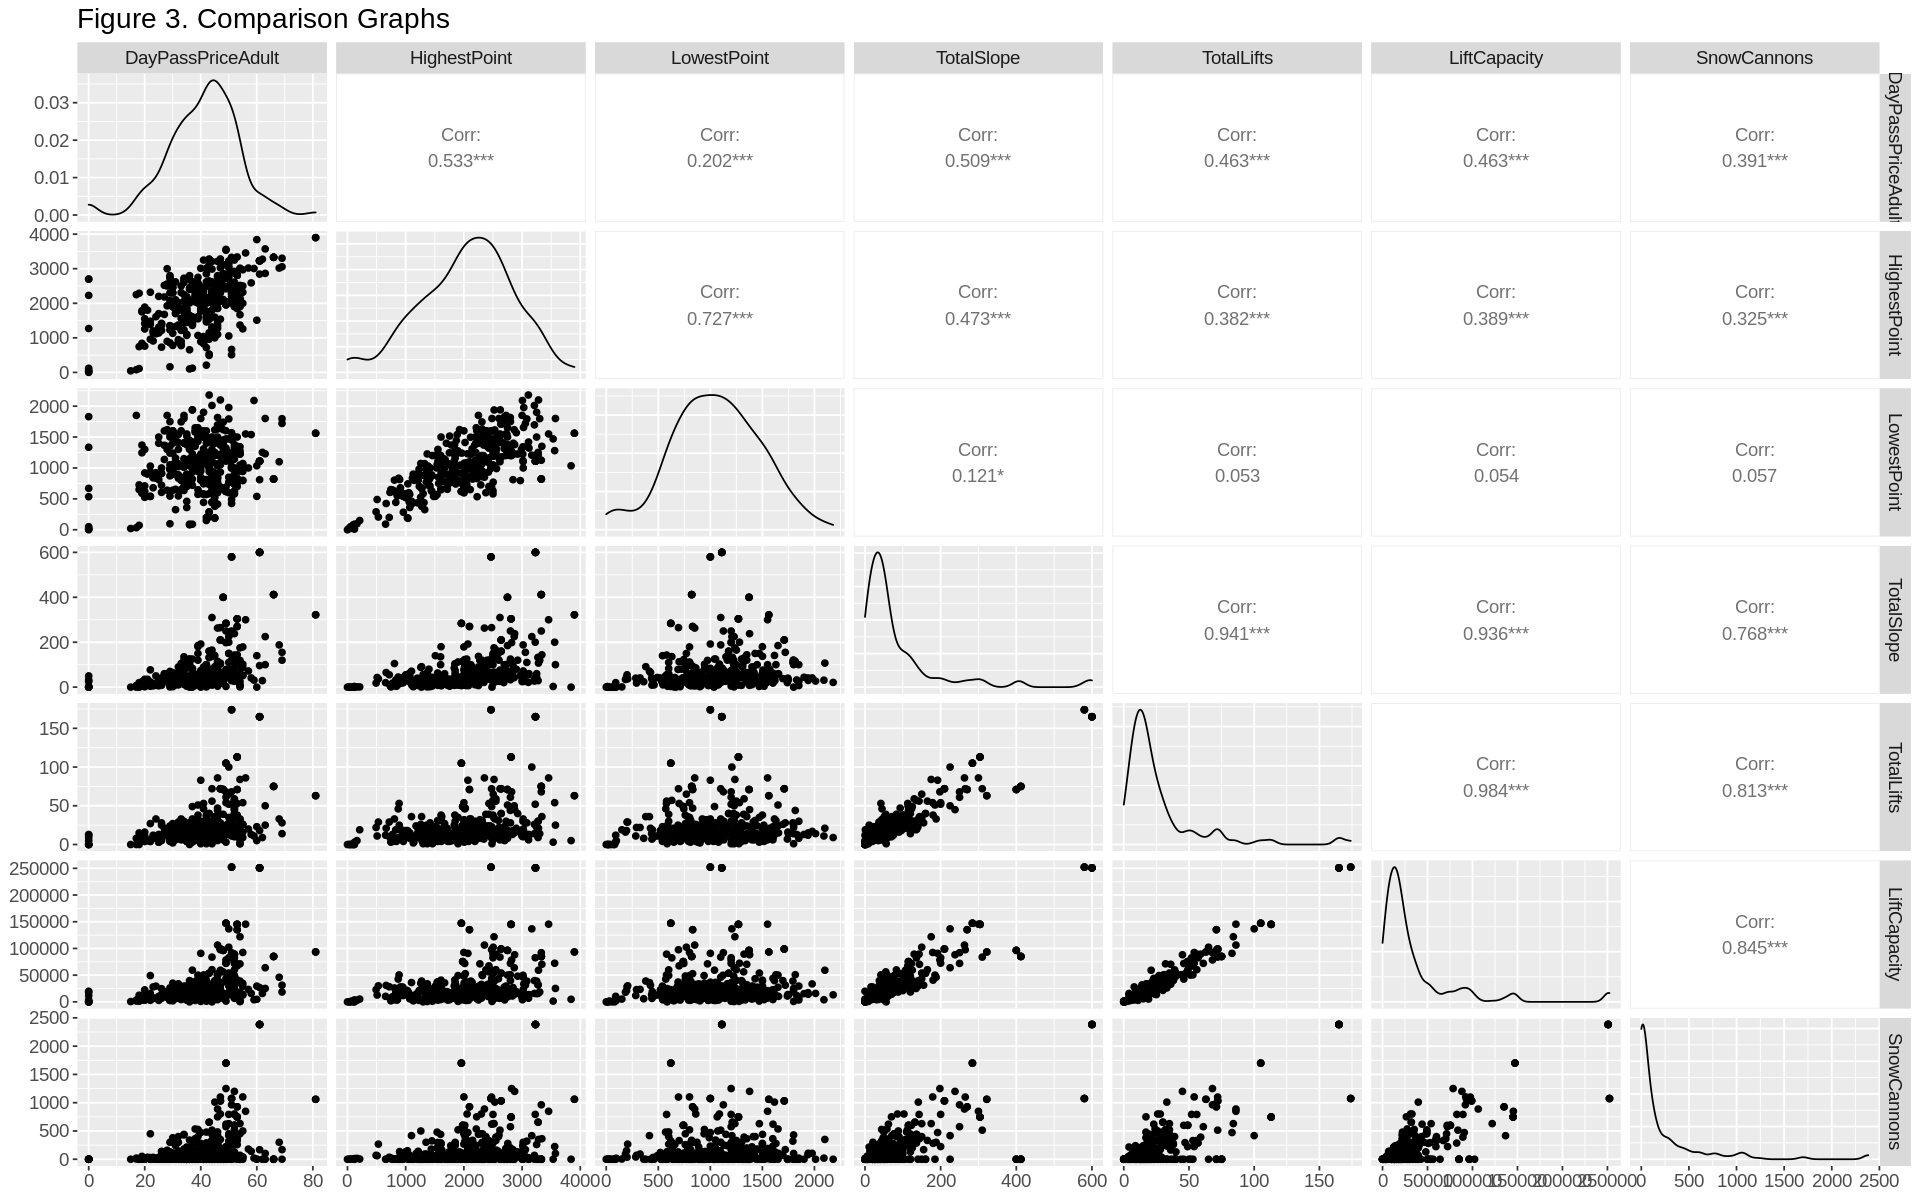

In [15]:
# Generating Correlation Matrix with ggpairs.
ggpairs(ski_data |>
    select(DayPassPriceAdult, HighestPoint, LowestPoint, TotalSlope, TotalLifts, LiftCapacity, SnowCannons)) +
    ggtitle("Figure 3. Comparison Graphs")+
    theme(text=element_text(size=14))
options(repr.plot.width = 40, repr.plot.height = 10)

As the data set it now cleaned and the main variables to model have beeen selected, we analyze our data and create the model.

### Regression Model

In [7]:
set.seed(5555)

workable_data <- ski_data |>
                select(DayPassPriceAdult, HighestPoint, LowestPoint, TotalSlope, TotalLifts, LiftCapacity, SnowCannons)|>
                keep(is.numeric)

ski_split <- initial_split(workable_data, prop = 0.70, strata = DayPassPriceAdult)  
ski_train <- training(ski_split)
ski_test <- testing(ski_split)

gridvals <- tibble(neighbors = seq(1, 10, 1))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("regression")

Here we select our identified variables of interest, found above using the numeric values calculated in our EDA. Then we split our data into training and testing segments to allow us to perform a proper multidimensional k-nearest neighbors regression, and having "new" data that our model has never seen before to test on. We continue to create our possible values of K so we can test which performs the best, and create our spec for our model.

In [8]:
ski_vfold <- vfold_cv(ski_train, v = 5, strata = DayPassPriceAdult)
ski_recipe <- recipe(DayPassPriceAdult ~ ., data = ski_train) |>
              step_scale(all_predictors()) |>
              step_center(all_predictors())

ski_fit <- workflow() |> 
           add_recipe(ski_recipe) |>
           add_model(knn_spec) |>
           tune_grid(resamples = ski_vfold, grid = gridvals) |>
           collect_metrics()|>
           filter(.metric == "rmse")

To determine our best value for K we created a plot of the percentage error compared with each value of K we tested, from 1 through 10. One key part to note is the flatness and similarity of all values of K from 4 to 10, which is addressed further in the discussion section.

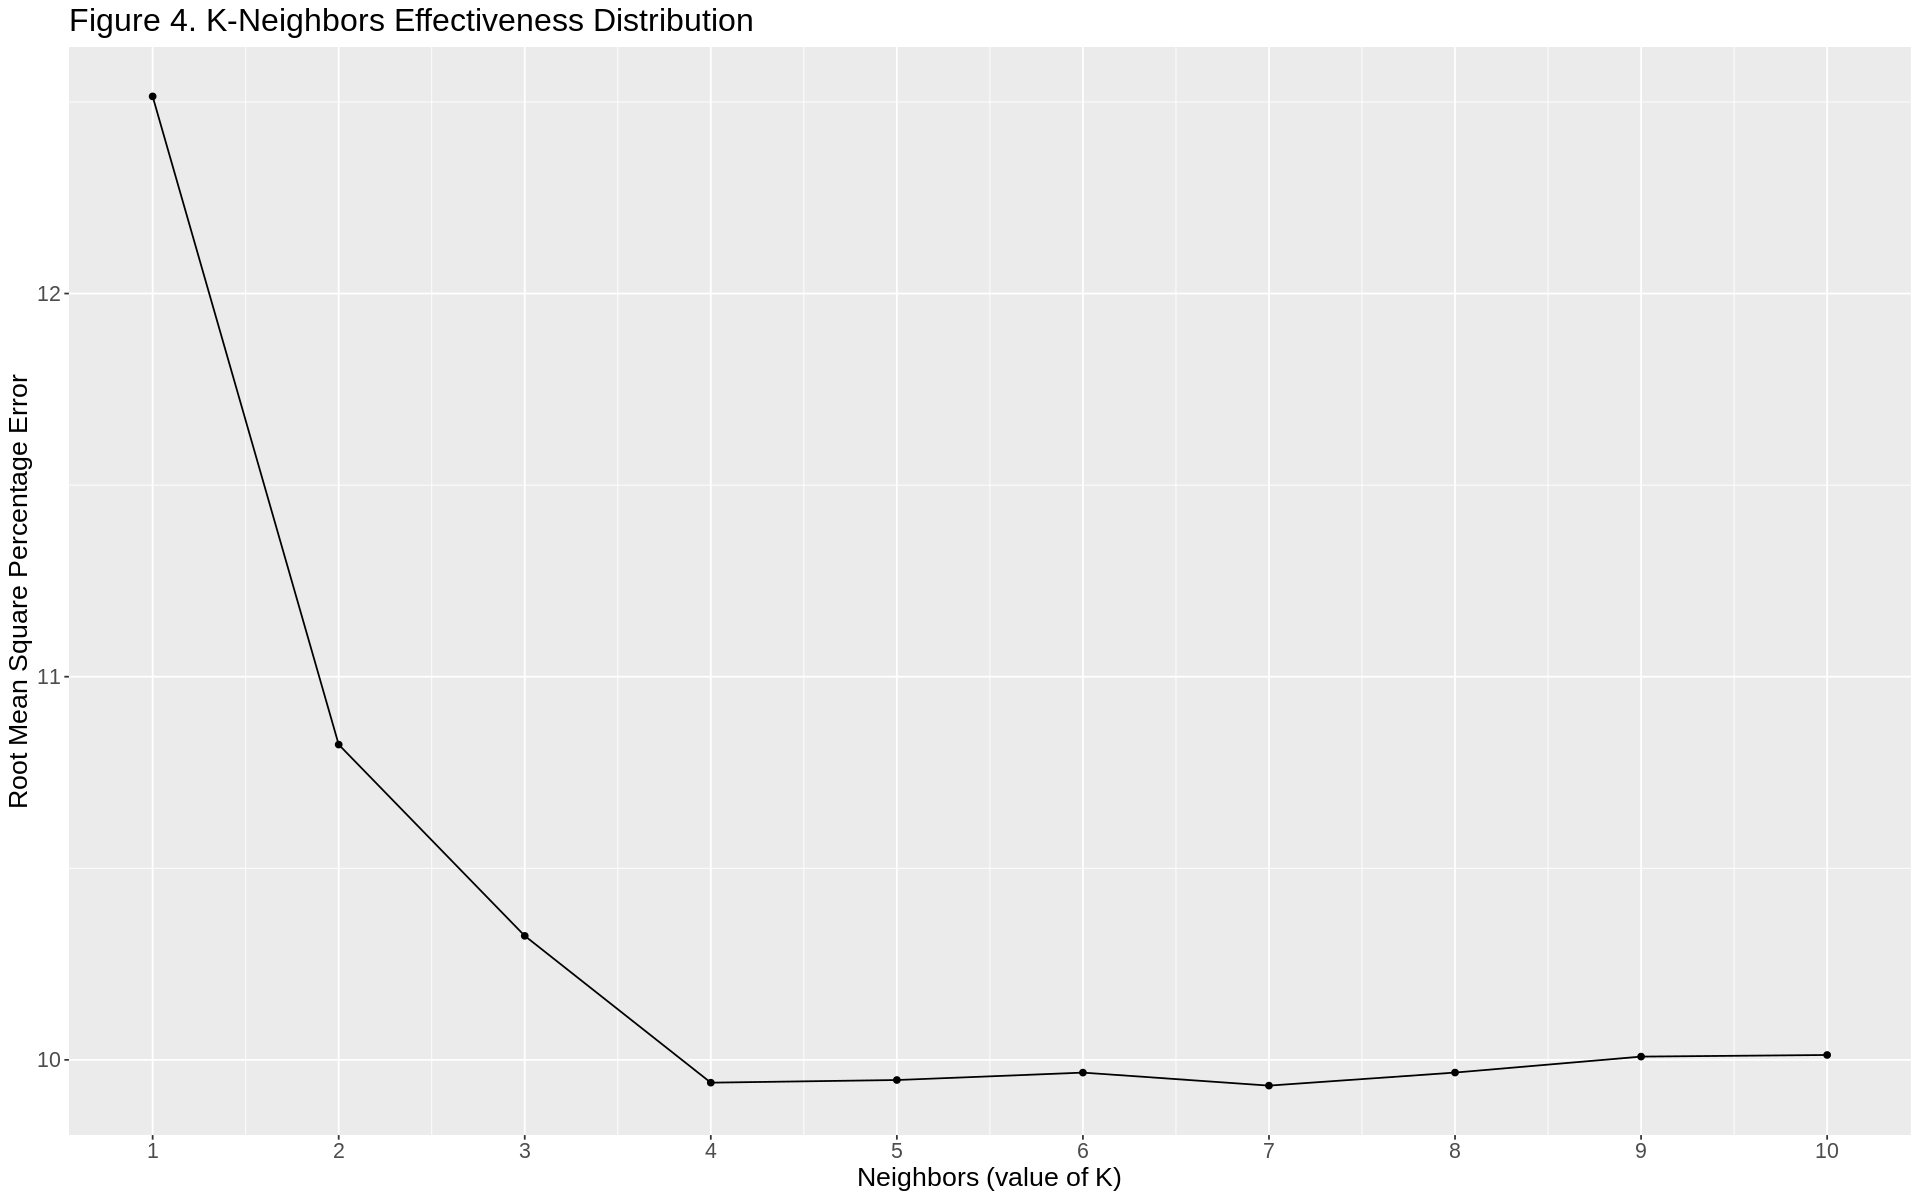

In [9]:
options(repr.plot.width = 16, repr.plot.height = 10)
ggplot(ski_fit, aes(x=neighbors,y=mean))+
        geom_point()+
        geom_line()+
        labs(x="Neighbors (value of K)",y="Root Mean Square Percentage Error")+
        ggtitle("Figure 4. K-Neighbors Effectiveness Distribution")+
        theme(text = element_text(size = 16))+
        scale_x_continuous(breaks = round(seq(0, 10, by = 1)))

We end up choosing our number of neighbors as K = 7. This is because it has the lowest error. We then begin to create our prediction model with the this K value. For simplicity we also change the names of .preds after the prediction and DayPassPriceAdult to Predicted and Actual.

In [10]:
ski_k <- ski_fit |>
           arrange(mean) |>
           filter(mean == min(mean))|>
           pull(neighbors)
ski_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = ski_k) |>
            set_engine("kknn") |>
            set_mode("regression")
err <- ski_fit |> filter(mean==min(mean))
err

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,rmse,standard,9.932767,5,0.4159635,Preprocessor1_Model07


From this we also find that our std_err is just over 40%! This concerning detail is covered further in the discussion.

In [16]:
ski_best_fit <- workflow() |>
          add_recipe(ski_recipe) |>
          add_model(ski_spec) |>
          fit(data = ski_train)

ski_summary <- ski_best_fit |>
           predict(ski_test) |>
           bind_cols(ski_test) |>
           metrics(truth = DayPassPriceAdult, estimate = .pred)

ski_preds <- ski_best_fit |>
           predict(ski_train)|>
           bind_cols(ski_train)
colnames(ski_preds)[1] = "Predicted"
colnames(ski_preds)[2] = "Actual"

After we have created our prediction model, we then create a table to compare the predictions and actual values.

### Model Visualization

In [12]:
ski_preds_compare <- ski_preds |>
                    select(Predicted,Actual)
"Table 1. Predicted Price from Model vs Actual Price"                 
ski_preds_compare

[1] "Table 1. Predicted Price from Model vs Actual Price"

Predicted,Actual
<dbl>,<dbl>
39.42857,22
25.57143,23
32.28571,18
37.28571,20
31.57143,22
30.42857,19
28.42857,22
38.57143,34
26.14286,25


There is a notable discrepancy between the predicted and actual values here, to better demonstrate this we moved onto our visualizations. We plotted the predictions and pass price against the highest point as it had the highest correlation value found earlier. We also coloured and shaped them based on their classification (predicted or actual).

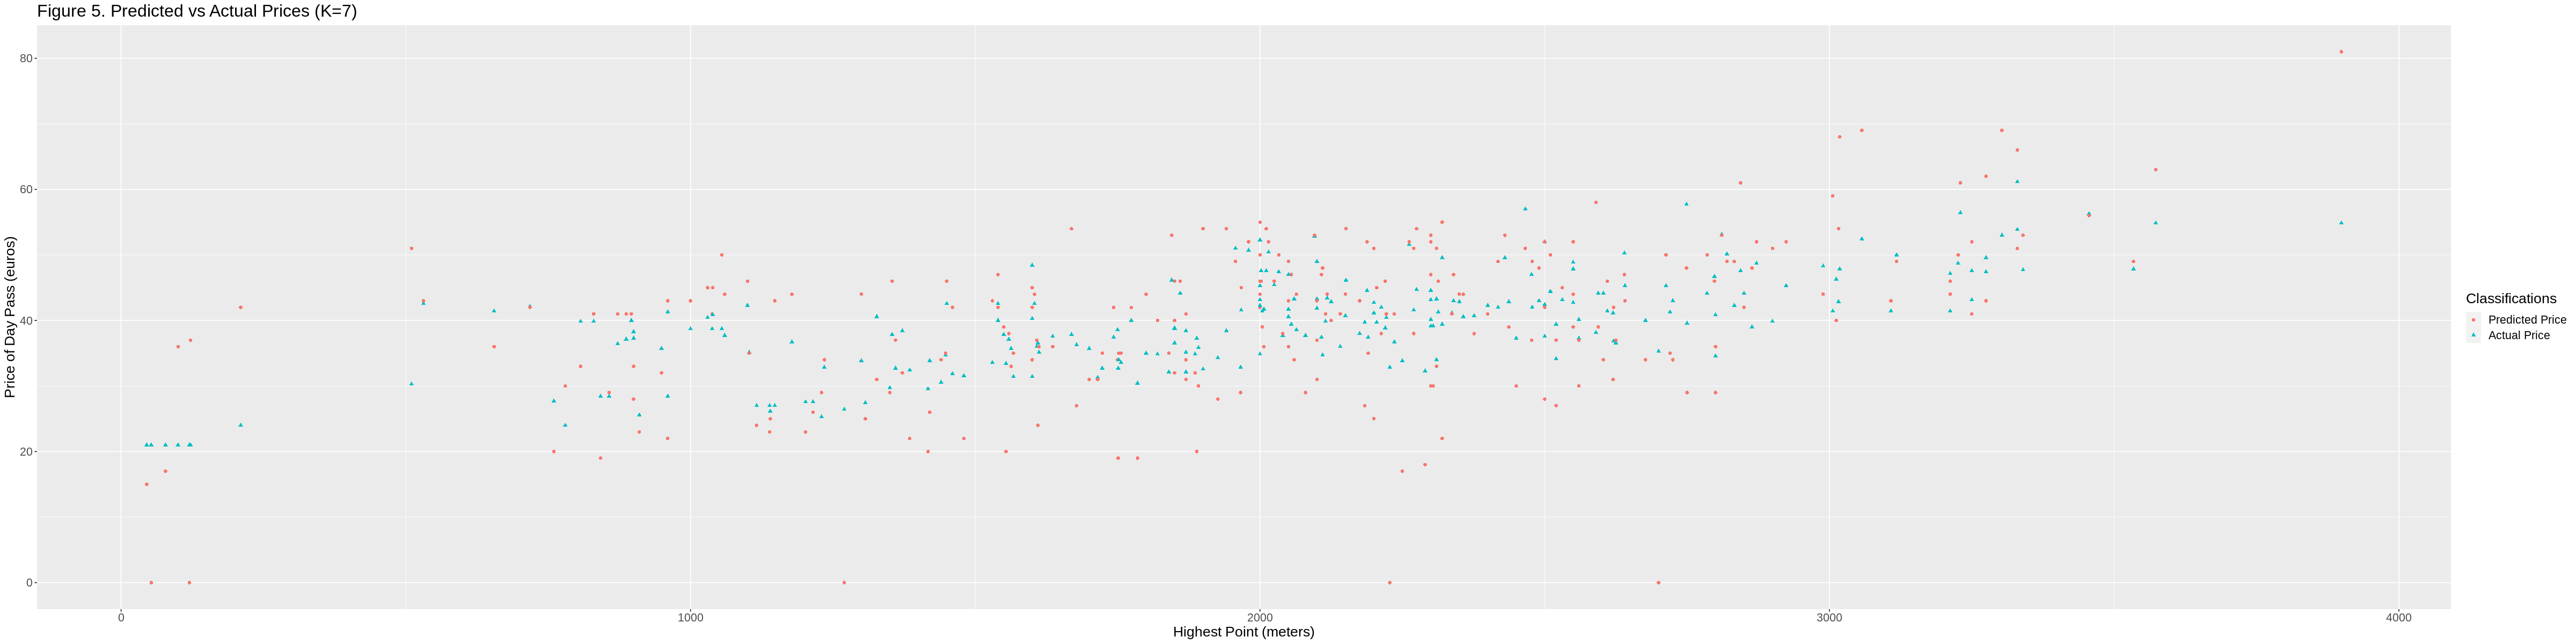

In [17]:
plot_data <- ski_preds |>
             pivot_longer(Predicted:Actual, values_to = "Price", names_to = "Classifications")
ggplot(plot_data, aes(x=HighestPoint,y=Price, color=Classifications, shape=Classifications))+
        geom_point()+
       labs(x="Highest Point (meters)", y="Price of Day Pass (euros)", title="Figure 5. Predicted vs Actual Prices (K=7)")+
       scale_shape_discrete(labels = c("Predicted Price","Actual Price"))+
       scale_colour_discrete(labels = c("Predicted Price", "Actual Price"))+
theme(text=element_text(size=16))

The graph shows the notable discrepancy between the Actual and Predicted values that was mentioned above. The red circles show what our values are, and the blue triangles show what they are predicted to be based on our prediction model. This difference tells us about the relevancy of our data to pricing which is talked about in our discussion.

To assist in understanding this difference we then graphed each of our main variables against our Actual Price with a prediction line (based on our prediction data). Not only does it aid in finding the trend of the data, it also shows inconsistencies between the predictions and actual values.

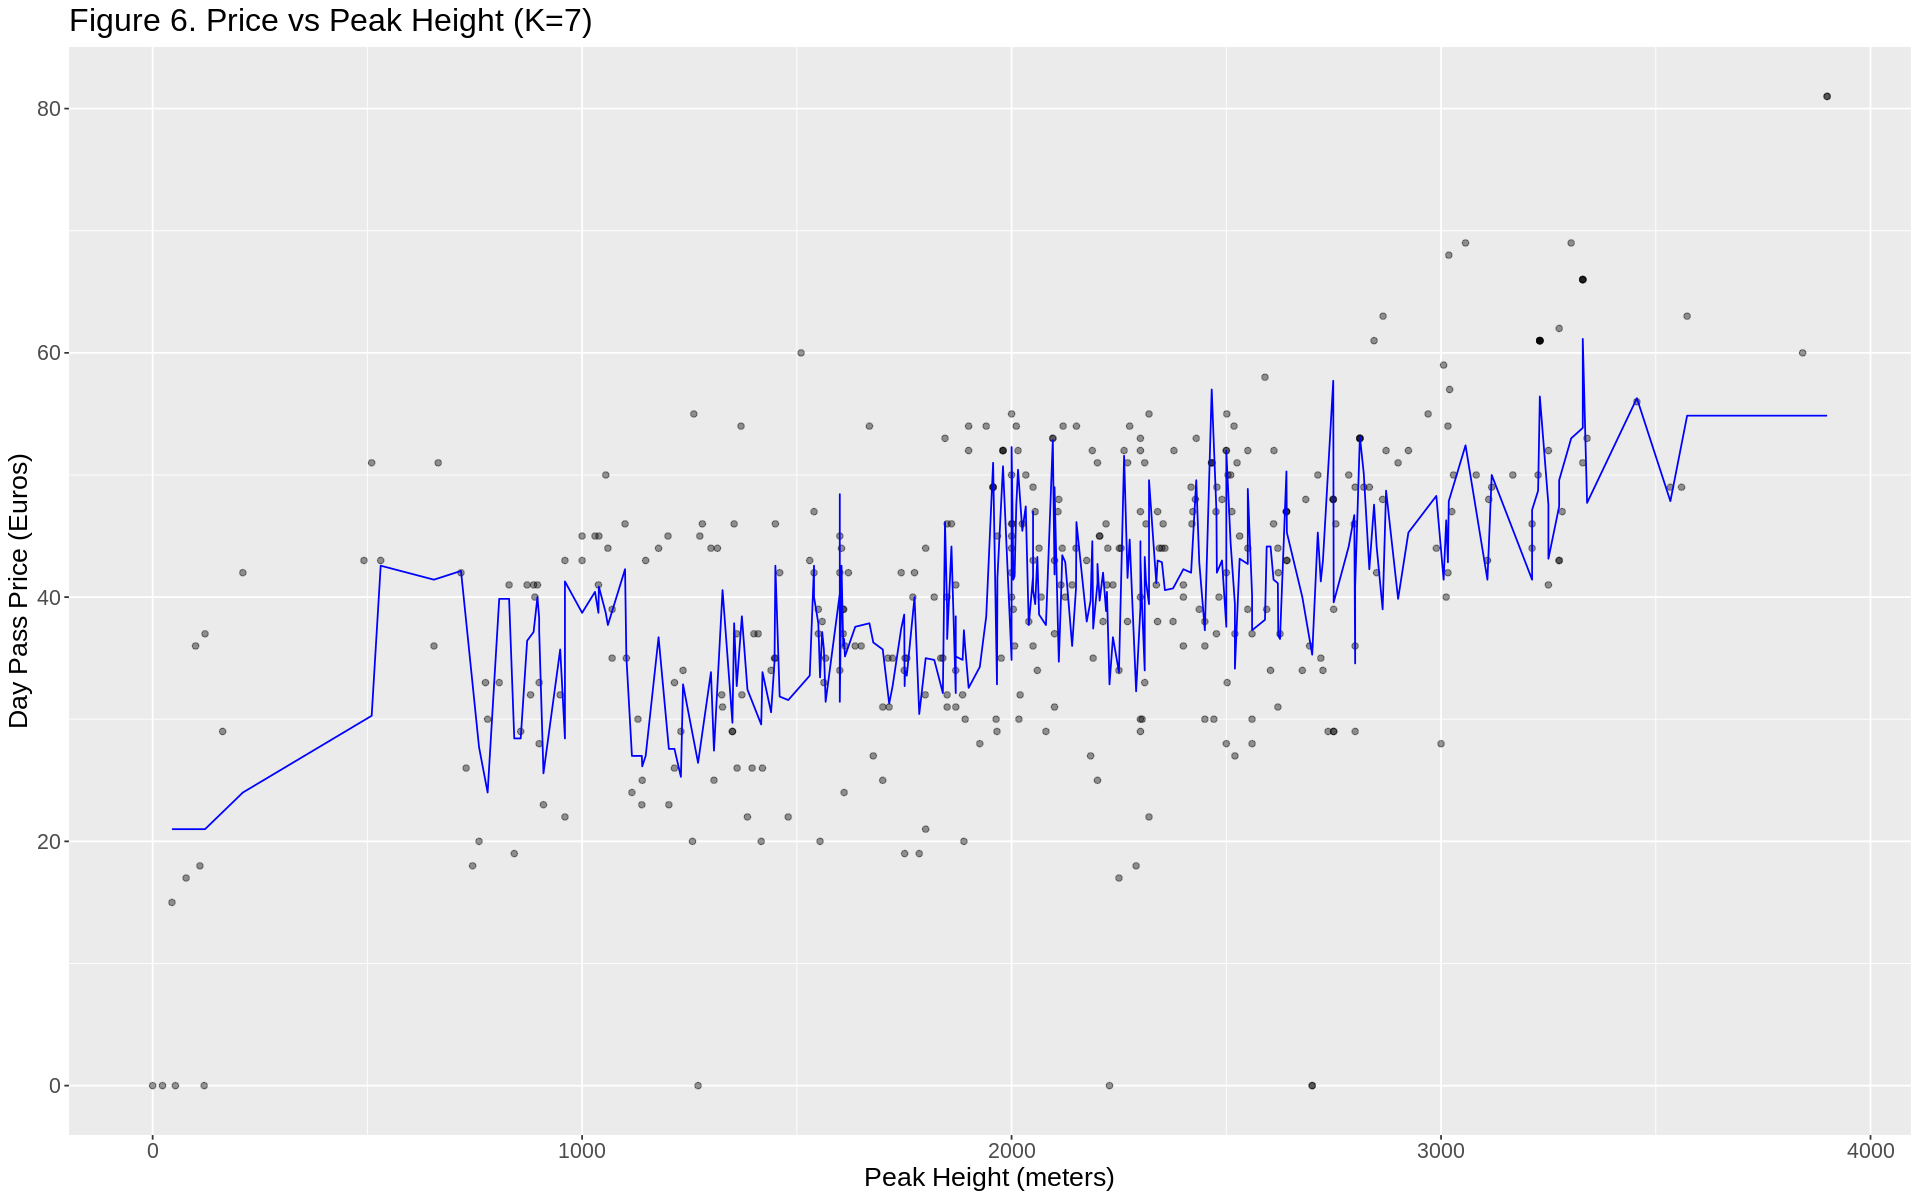

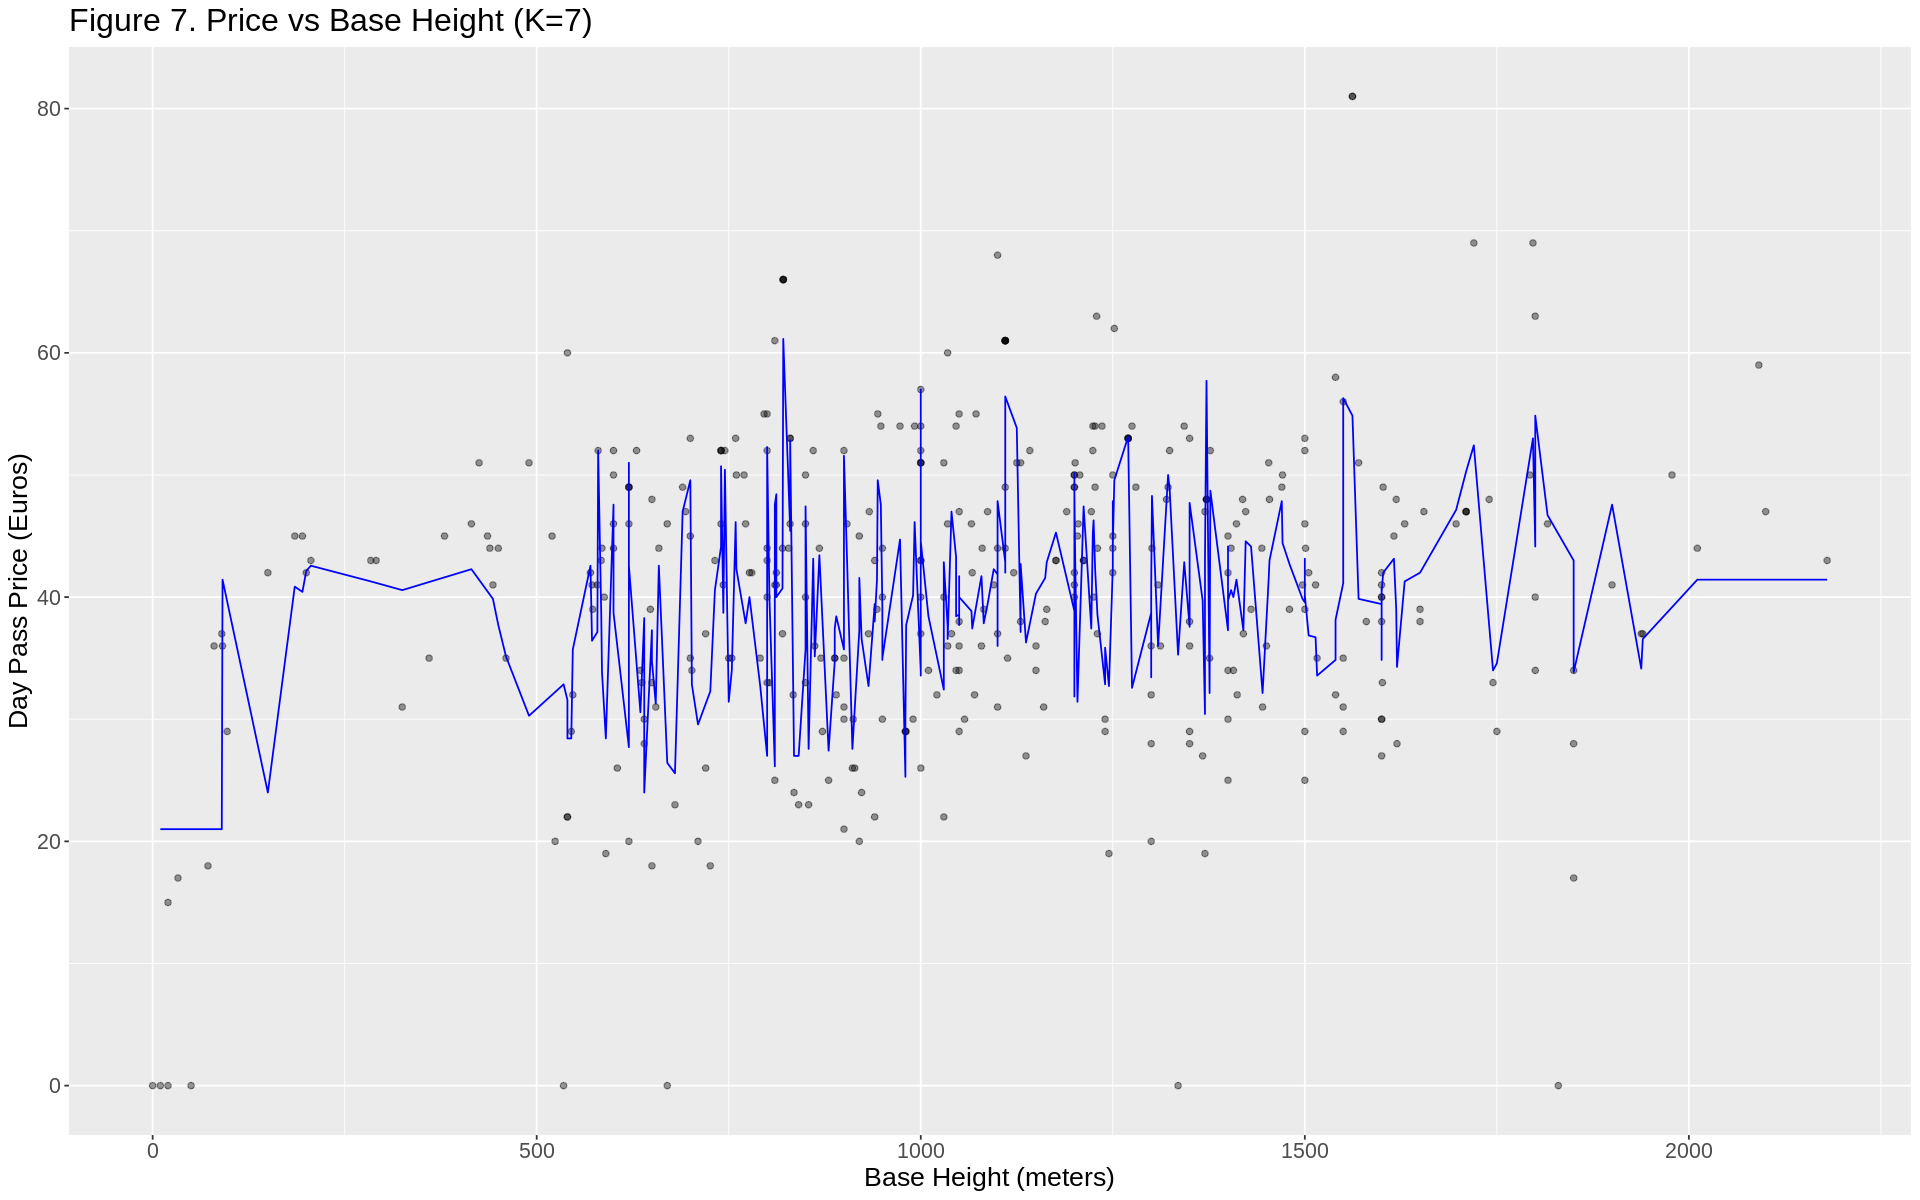

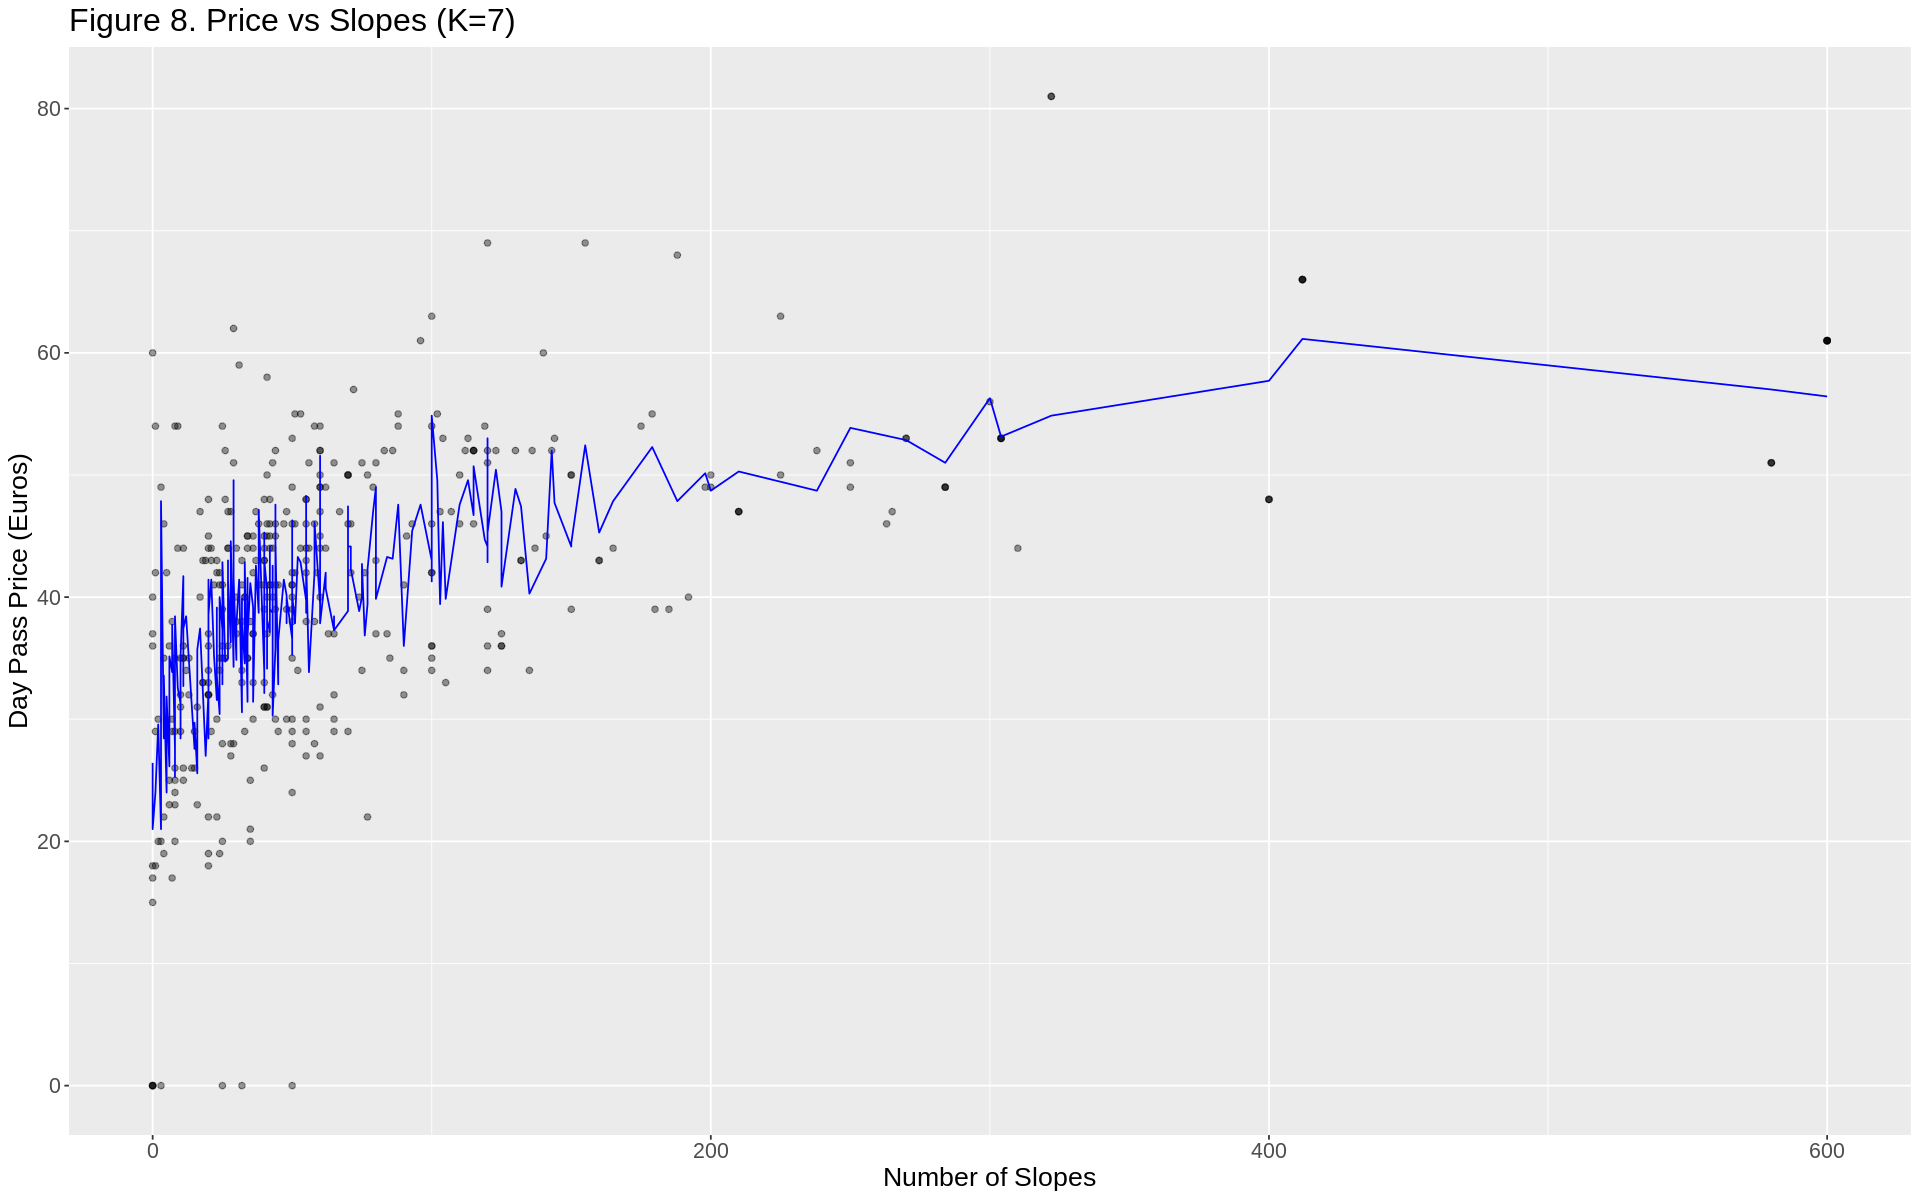

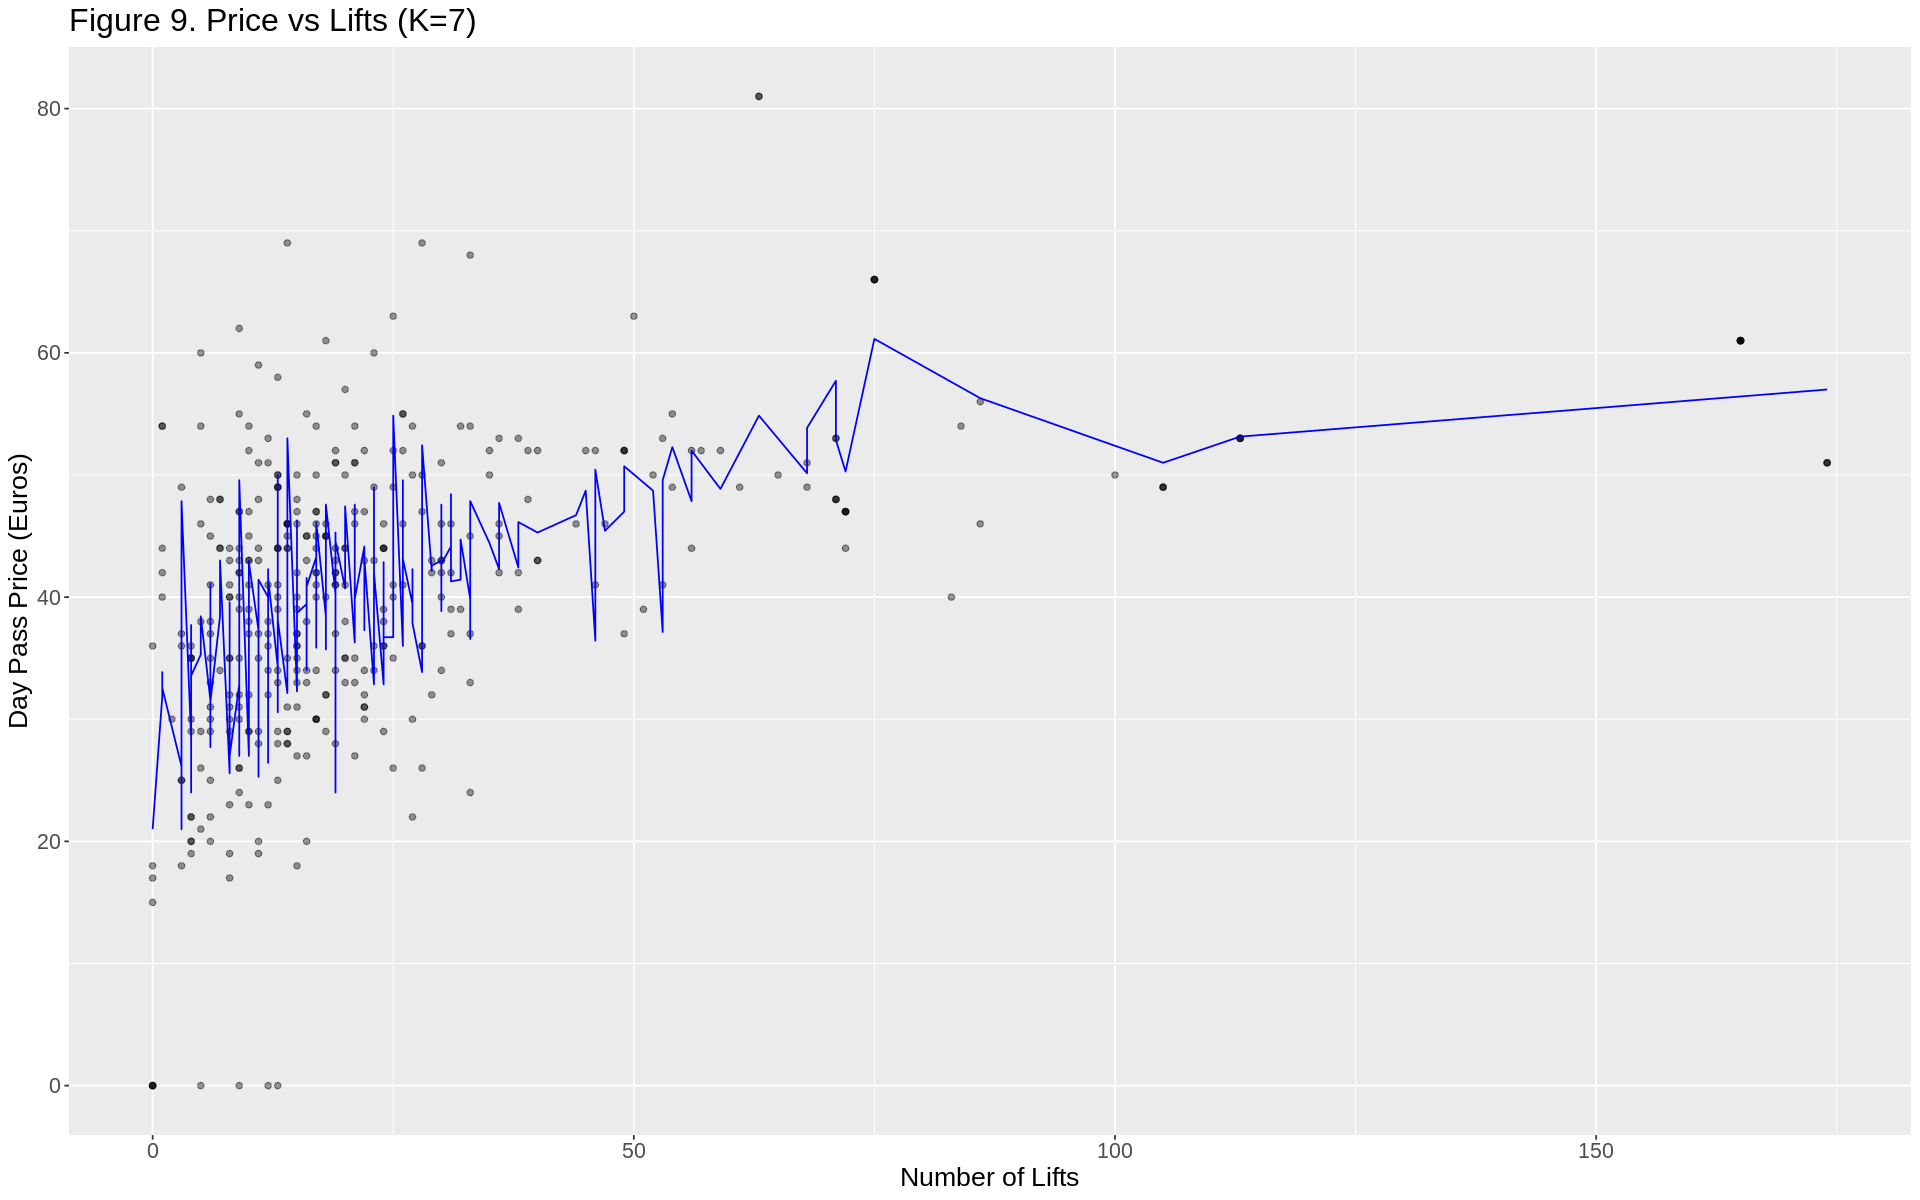

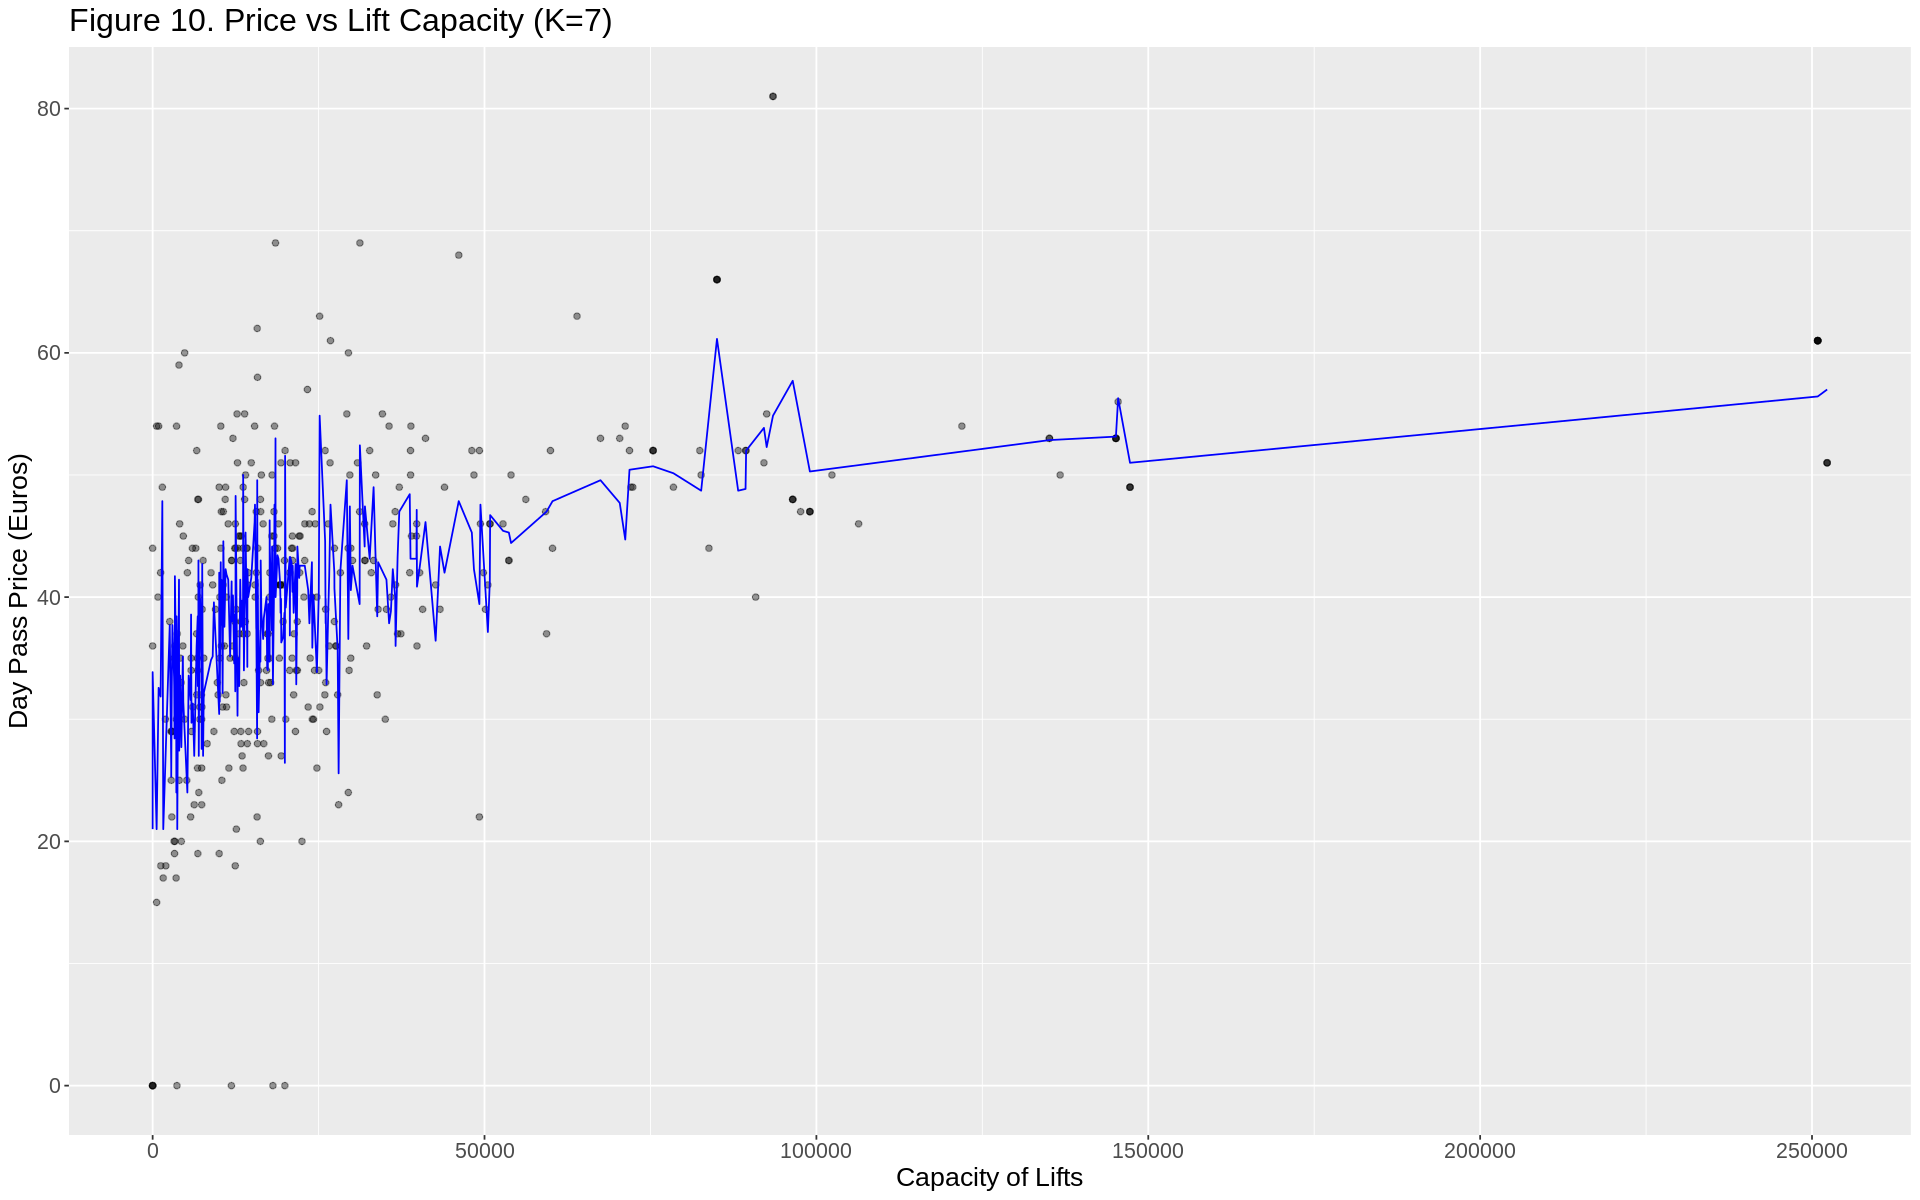

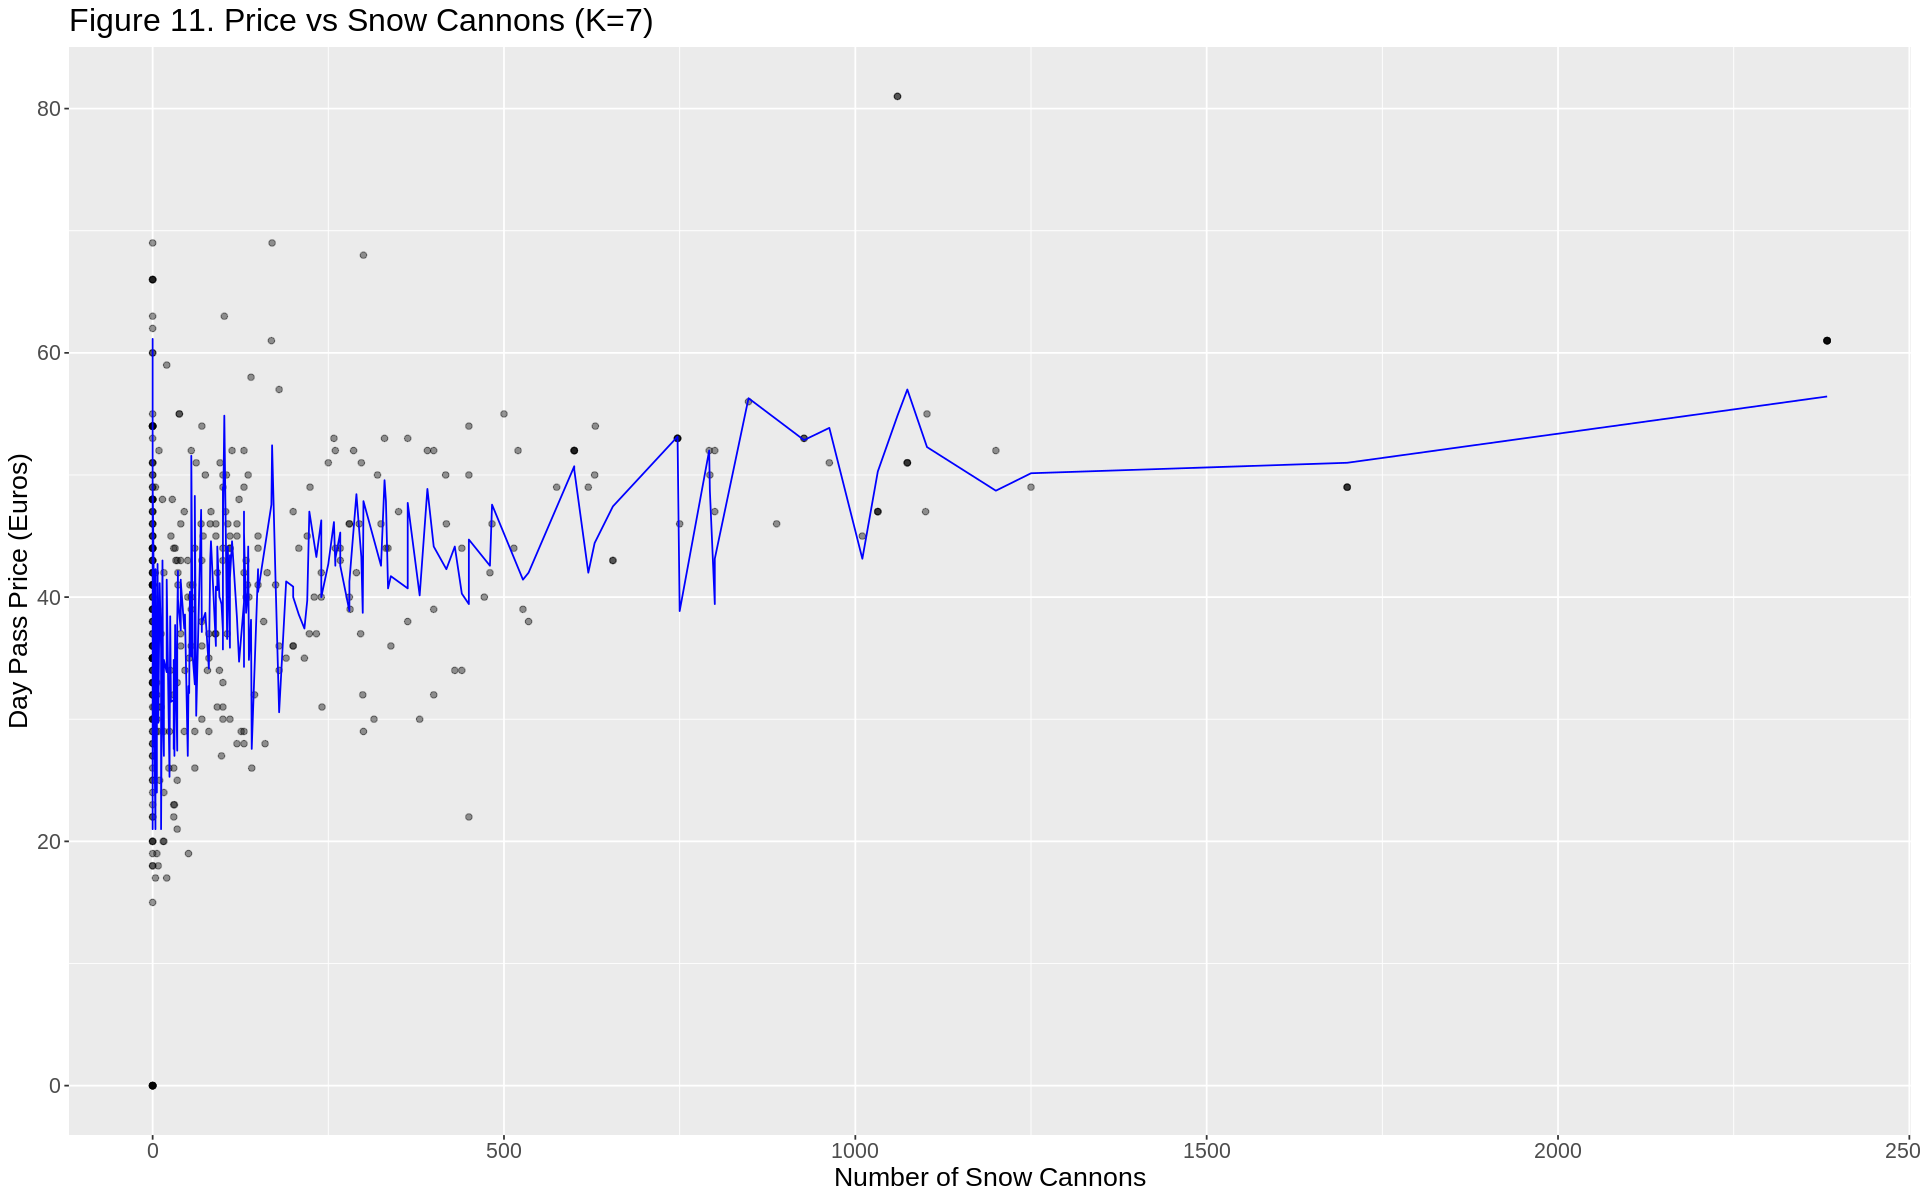

In [14]:
#individual plots for each variable
ggplot(workable_data, aes(x = HighestPoint, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = HighestPoint, y = Predicted), 
            color = "blue") +
  xlab("Peak Height (meters)") +
  ylab("Day Pass Price (Euros)") +
  ggtitle("Figure 6. Price vs Peak Height (K=7)") + 
  theme(text = element_text(size = 16))

ggplot(workable_data, aes(x = LowestPoint, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = LowestPoint, y = Predicted), 
            color = "blue") +
  xlab("Base Height (meters)") +
  ylab("Day Pass Price (Euros)") +
  ggtitle("Figure 7. Price vs Base Height (K=7)") + 
  theme(text = element_text(size = 16))

ggplot(workable_data, aes(x = TotalSlope, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = TotalSlope, y = Predicted), 
            color = "blue") +
  xlab("Number of Slopes") +
  ylab("Day Pass Price (Euros)") +
  ggtitle("Figure 8. Price vs Slopes (K=7)") + 
  theme(text = element_text(size = 16))

ggplot(workable_data, aes(x = TotalLifts, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = TotalLifts, y = Predicted), 
            color = "blue") +
  xlab("Number of Lifts") +
  ylab("Day Pass Price (Euros)") +
  ggtitle("Figure 9. Price vs Lifts (K=7)") + 
  theme(text = element_text(size = 16))

ggplot(workable_data, aes(x = LiftCapacity, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = LiftCapacity, y = Predicted), 
            color = "blue") +
  xlab("Capacity of Lifts") +
  ylab("Day Pass Price (Euros)") +
  ggtitle("Figure 10. Price vs Lift Capacity (K=7)") + 
  theme(text = element_text(size = 16))

ggplot(workable_data, aes(x = SnowCannons, y = DayPassPriceAdult)) +
  geom_point(alpha = 0.4) +
  geom_line(data = ski_preds, 
            mapping = aes(x = SnowCannons, y = Predicted), 
            color = "blue") +
  xlab("Number of Snow Cannons") +
  ylab("Day Pass Price (Euros)") +
  ggtitle("Figure 11. Price vs Snow Cannons (K=7)") + 
  theme(text = element_text(size = 16))

## Discussion

Through our regression model we expected to see a strong relationship between the price of a day pass for adults and factors such as number of Slopes or the existence of snow cannons. We expected there to be strong predictors for the price of day passes as they can vary from as little as 15 euros to over 80 euros in our data. Given most skiers seek larger mountains, more runs and more snow, we predicted Peak Height, Number of Slopes and Snow Cannons to be the most impactful predictors featured in the data.

We were amazed to find that most categories had very little effect on the price of day passes at all. The unlinked nature of this data caused great difficulties in the creation of our regression model as there was weak correlation between nearly all of our categories with our resulting variable. Even testing a larger number of *k* neighbors still netted a similar level of model effectiveness to the *k* we've chosen to use in the model above. In the end our std_err came out to roughly 40%! However, of the three categories we had hope for, two came through as more accurate predictors than the rest. The Peak Height and the Number of Slopes had a visible positive relationship with our resulting day pass price.

Such findings indicates that most of the prices are more arbitrarily invented than we thought, apparently not accurately representing the quality or difficultly of the resort or terrain. While ski resorts do require runs, elevation and facilites to charge their prices, those factors seem to have little, if no correlation to the final decided price for the lift tickets. Interestingly, they continue to rise with an expected increase of 6-10% coming in future ski seasons (Lang, 2021). Next steps are to find out why this is the case!

Our findings leave us with many further unresolved research questions, such as:
- If the number of existing ski resorts decreases, will prices increase further?
- If more ski resorts are created, increasing competition, will prices gain a stronger relation to the aspects/facilities of the hill?
- How can lift ticket prices be maximized while facilites are minimized?
- If not correlated directly with the quality of the resort and its equipment or facilities, what exactly goes into pricing a ski lift ticket?

## References

European Commission. (2021). Quarterly research and innovation literature review: Business, innovation and productivity. Directorate-General for Research and Innovation. Retrieved April 13, 2023, from https://research-and-innovation.ec.europa.eu/system/files/2022-02/ec_rtd_quarterly-ri-review_042021.pdf.

Lang, S. (2021, October 17). Ski passes in Europe ski resorts will be more expensive. TopSkiResort.com. Retrieved April 13, 2023, from https://rb.gy/dqp3g.

Nibb, Thomas. (2022, February). European Ski Resorts, Version 1 [Dataset]. Retrieved April 13, 2023 from https://www.kaggle.com/datasets/thomasnibb/european-ski-resorts.